## 📦 Step 1: Install Dependencies

We'll install required Python libraries:
- `opencv-python` for image loading
- `matplotlib` for visualization
- `torch`, `torchvision` for model training/inference


In [13]:
!pip install -q opencv-python matplotlib torchvision
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


## 🧠 Step 2: Define a Simple U-Net Architecture

We'll define a lightweight U-Net model that performs segmentation on 2D MRI brain slices.


In [14]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),
            nn.Conv2d(16, 1, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.decoder(x)
        return torch.sigmoid(x)


## 🧠 Step 3: Generate Synthetic MRI Slice and Mask (No Download Needed)

Since external links are failing, we’ll generate a synthetic MRI brain slice using NumPy and create a simple circular mask to simulate a tumor region.


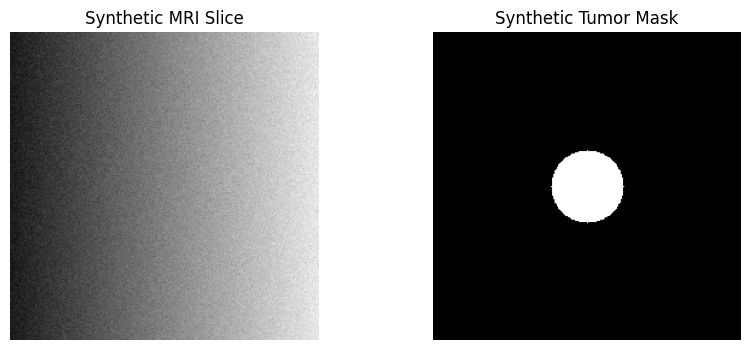

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Generate a synthetic MRI (grayscale gradient with noise)
img = np.tile(np.linspace(0, 255, 256), (256, 1)).astype(np.float32)
img += np.random.normal(0, 10, img.shape).astype(np.float32)

# Create a circular tumor mask in the center
mask = np.zeros_like(img, dtype=np.float32)
cv2.circle(mask, (128, 128), 30, (255), -1)

# Normalize to [0, 1]
img = img / 255.0
mask = mask / 255.0

# Display both
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Synthetic MRI Slice")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Synthetic Tumor Mask")
plt.axis("off")
plt.show()


## 🧠 Step 4: Define a Simple U-Net Model for Segmentation

This is a lightweight version of U-Net that can segment tumor regions from grayscale MRI slices. It uses:
- Two encoding conv layers
- Max pooling
- One decoding layer with upsampling


In [18]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.pool(x)
        x = self.decoder(x)
        return x

# Instantiate model
model = UNet()


## 🎯 Step 5: Run Inference Using U-Net and Visualize the Prediction

We will:
- Convert the synthetic MRI image into a PyTorch tensor
- Pass it through the untrained U-Net model
- Visualize the predicted mask alongside the original input and ground truth


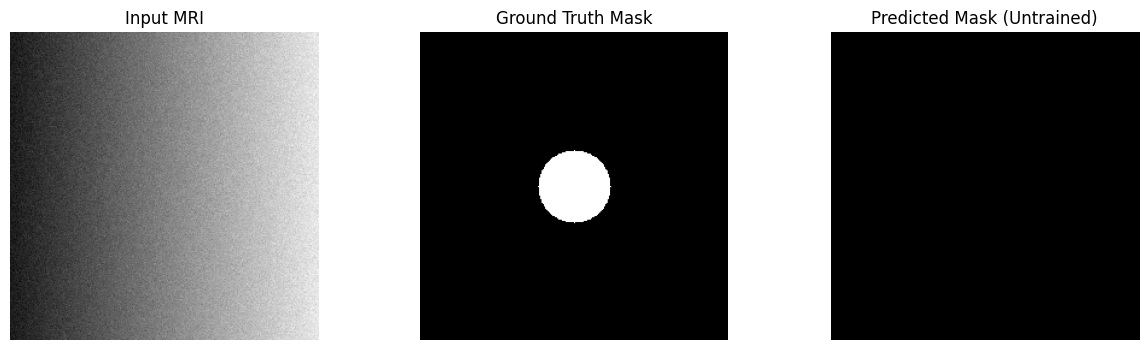

In [19]:
# Convert image to PyTorch tensor (shape: [1, 1, H, W])
input_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()

# Get prediction from model
with torch.no_grad():
    prediction = model(input_tensor).squeeze().numpy()

# Threshold the prediction for visualization
binary_pred = (prediction > 0.5).astype(np.float32)

# Display all: original, ground truth, prediction
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Input MRI")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(binary_pred, cmap='gray')
plt.title("Predicted Mask (Untrained)")
plt.axis("off")

plt.show()


## 🧪 Step 6: Train U-Net on the Synthetic MRI Slice

We’ll train our U-Net for a few epochs using:
- Binary Cross Entropy (BCE) Loss
- Adam optimizer
Even though we only have one image, this is just to show the training loop works.


In [20]:
# Convert mask to tensor and reshape
target_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (5 epochs)
for epoch in range(5):
    model.train()
    optimizer.zero_grad()

    output = model(input_tensor)
    loss = criterion(output, target_tensor)
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/5], Loss: {loss.item():.4f}")


Epoch [1/5], Loss: 0.6040
Epoch [2/5], Loss: 0.6020
Epoch [3/5], Loss: 0.5998
Epoch [4/5], Loss: 0.5974
Epoch [5/5], Loss: 0.5949


## 📊 Step 7: Evaluate Model with Dice Score and Visualize Final Prediction

The Dice Score measures overlap between the predicted mask and the ground truth mask. A value of 1.0 means perfect prediction.
We’ll:
- Predict again with the trained model
- Threshold the mask
- Calculate Dice
- Display results


🎯 Dice Score: 0.0000


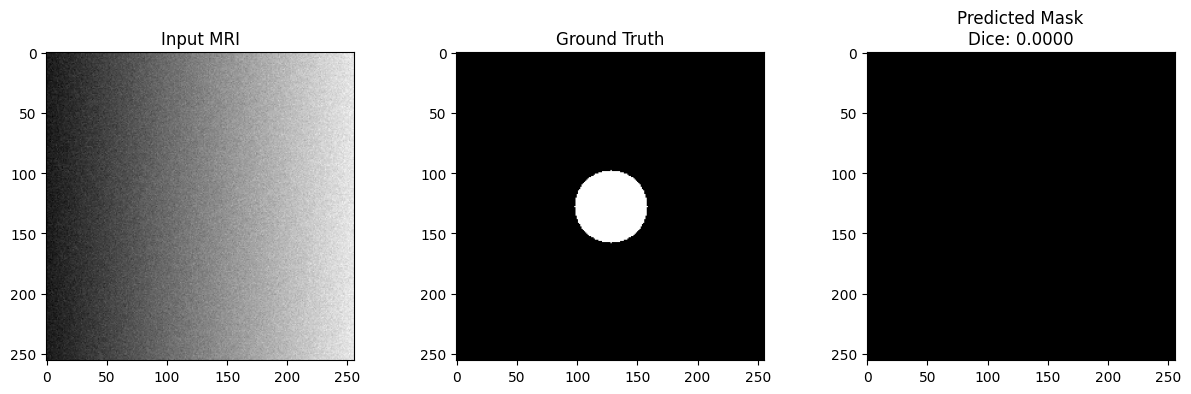

In [21]:
# Predict again after training
model.eval()
with torch.no_grad():
    prediction = model(input_tensor).squeeze().numpy()
    binary_pred = (prediction > 0.5).astype(np.float32)

# Flatten arrays to calculate Dice
flat_pred = binary_pred.flatten()
flat_true = mask.flatten()

# Dice coefficient function
def dice_score(pred, target):
    intersection = np.sum(pred * target)
    return (2. * intersection) / (np.sum(pred) + np.sum(target) + 1e-8)

# Calculate and print Dice
dice = dice_score(flat_pred, flat_true)
print(f"🎯 Dice Score: {dice:.4f}")

# Show prediction vs ground truth
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Input MRI")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(binary_pred, cmap='gray')
plt.title(f"Predicted Mask\nDice: {dice:.4f}")
plt.show()
